# OKCupid Date-A-Scientist Project
## Analysis of user profiles from the matchmaking app

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

AttributeError: module 'scipy.sparse.linalg' has no attribute 'cg'

In [2]:
import scipy
print(scipy.__version__)

1.17.0


**My first step will be to load and preview the data. I will see which questions arise and explore the best ways to answer them.**

In [2]:
data = pd.read_csv('profiles.csv')

In [3]:
data.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


**Upon initial inspection of the data, I notice that some data is missing. I also notice that most columns contains strings.**

**Most of the features are categorical and will have to be one-hot encoded.**

**Next, I'll get a better picture of how much data is missing, data types, and scale of numerical variables.**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

In [5]:
data.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


**The income variable is on a much greater scale than age and height, so it makes sense to standardize these before building a model.**

**I would like to predict whether or not a user is single or in a relationship. For this classification problem, I will use a logistic regression model.**

**First, I need to prepare the data for use by the model. I will create my feature matrix X and target vector y. In the feature matrix, I will include age, body_type, diet, drinks, drugs, education, height, income, job, pets, sign, amd smokes.**

In [6]:
data = data[data['status'] != 'unknown']
data['single'] = data["status"].map({"single": 1, "available": 1, "seeing someone": 0, "married": 0})
data['single'].value_counts()

single
1    57562
0     2374
Name: count, dtype: int64

**The classes are heavily imbalanced. It would be interesting to build a model that is good at predicting the negative class. In other words, I would like to build a model that makes few false positive predictions (i.e has high precision).**

In [7]:
data = data.dropna(subset = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'height', 'income', 'job', 'pets', 'sign', 'smokes'])
data = data[data['income'] != -1].reset_index(drop=True)

<Axes: xlabel='income', ylabel='Count'>

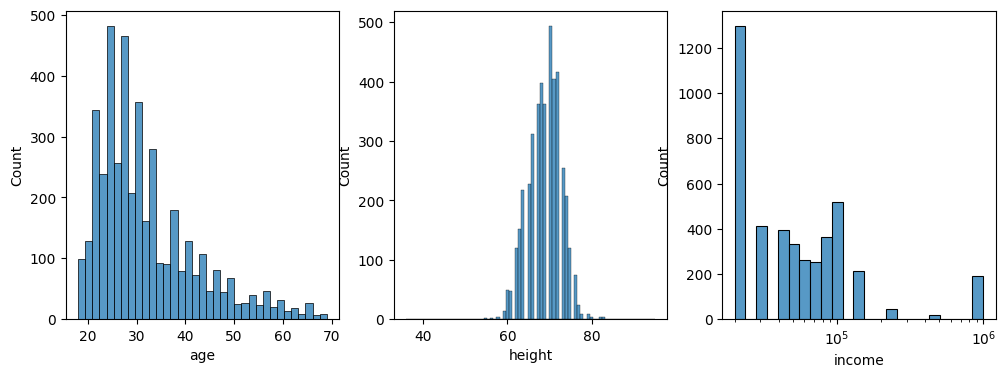

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
sns.histplot(data=data.age, ax=axes[0])
sns.histplot(data=data.height, ax=axes[1])
sns.histplot(data=data.income, log_scale=True, ax=axes[2])

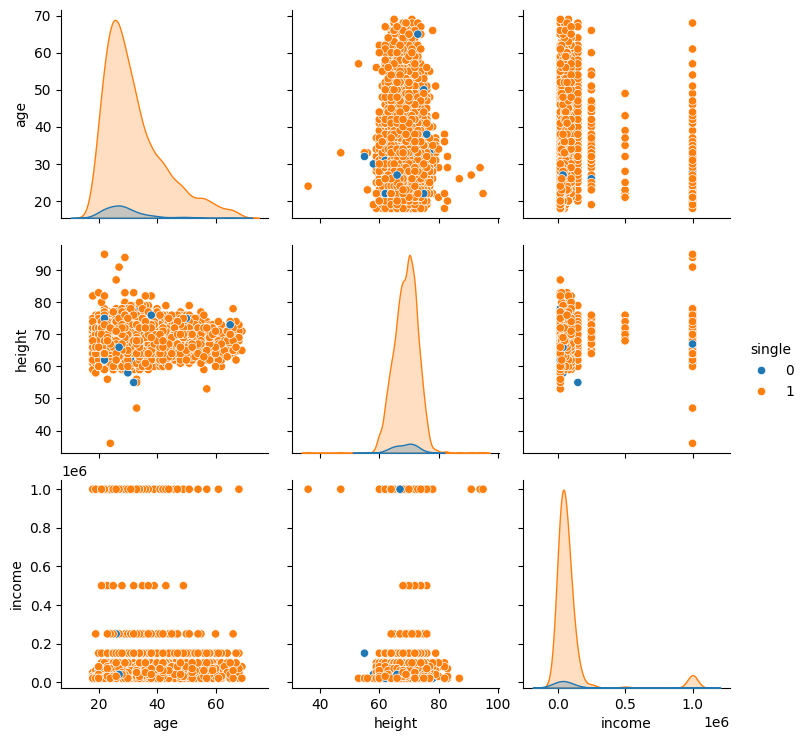

In [30]:
sns.pairplot(data=data, vars=['age', 'height', 'income'], hue='single')

In [10]:
X = data[['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'height', 'income', 'job', 'offspring', 'orientation', 'pets',
       'religion', 'sign', 'smokes', 'speaks']]
y = data['single']

In [11]:
X = pd.get_dummies(X, drop_first=True, dtype=float)

In [12]:
scaler = StandardScaler()

In [13]:
X[["age", "height", "income"]] = pd.DataFrame(scaler.fit_transform(X[["age", "height", "income"]]))

In [15]:
X.head()

,age,height,income,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,...,"speaks_english, spanish, italian (poorly)","speaks_english, spanish, portuguese, italian","speaks_english, swedish (fluently)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, yiddish (poorly)"
0,0.301196,0.283839,-0.098184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.389965,0.793220,-0.297495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.291228,-1.753687,-0.247667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.301196,1.047911,0.250611,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.291228,-0.480233,-0.297495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
lr = LogisticRegression()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

In [18]:
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [19]:
y_pred = lr.predict(X_test)

In [28]:
print(confusion_matrix(y_test, y_pred))

[[  2  33]
 [  1 824]]


In [21]:
accuracy_score = accuracy_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

In [25]:
print(accuracy_score)
print(precision_score)
print(recall_score)
print(f1_score)

0.9604651162790697
0.9614935822637106
0.9987878787878788
0.9797859690844233


**The scores here look very good, but the model seems to predict the positive class (not in a relationship) almost every time. This relates to the fact that the classes are imbalanced with almost all users not being in a relationship.**

In [32]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [33]:
lr_balanced.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [34]:
y_pred_balanced = lr_balanced.predict(X_test)

In [36]:
print(confusion_matrix(y_test, y_pred_balanced))

[[ 14  21]
 [152 673]]


**We have to reduce the dimensionality of the data, as there are currently over 1000 features.**

RuntimeError: `logistic=True` requires statsmodels, an optional dependency, to be installed.

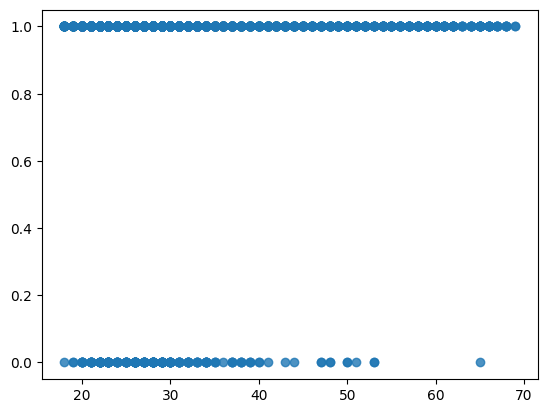

In [40]:
sns.regplot(x='age', y='single', data= data, logistic= True)